### META-LEARNING SIMULATION

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim

device='cuda'


### LOADING THE DATA

The cell below loads the devices responses. If Single_R=False, the data will be loaded from all the devices in the physical neural network, if Single_R=True, the code will load the data from a single device.

The PNN is driven by an external sinuoisodal signal $$s(t)=\sin(\omega t) $$, and it is tasked to reproduce different outputs $y_i(t)=a_i\sin(\omega_i t+\theta_i)$ in a few-shot learning fashion and as described in the paper.




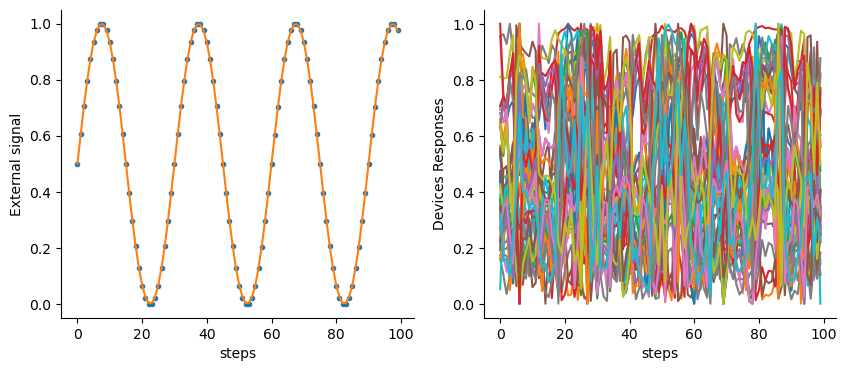

In [2]:
datafolder='Sine_hierachies'
X=[]
T_data=250
X=np.zeros([T_data,1])
S=np.zeros([T_data,1])

Single_R=False

if Single_R==True:
        
        ## Loading signle device response
        X1=np.load(os.path.join(datafolder,'7.ASVI04_From_HDS_Mem_peak_262.npy'),allow_pickle=True) 
        
else:
    
    
    ## Loading physical neural network response
    for file in os.listdir(datafolder):

        if '.npy' in file: 

            X1=np.load(os.path.join(datafolder,file),allow_pickle=True)
            if np.shape(X1)[0]>=T_data and file !='all_targets.npy' and file!='target_names.npy' and file!='3.Pinwheel_ASVI_y.npy':

                X=np.concatenate([X,X1[0:T_data,1:]],1)  

S1=np.load(os.path.join(datafolder,'3.Pinwheel_ASVI_y.npy'),allow_pickle=True)
X=np.concatenate([X,S1[0:T_data,2:]],1)

S=S1[0:T_data,0]
S=(S-np.min(S))/(np.max(S)-np.min(S))


## Plot external Signal and response example
fig, ax = plt.subplots(1, 2,figsize=(10, 4))

ax[0].plot(S[0:100],'.')
dts=torch.arange(0,250)*2*np.pi/30
ax[0].plot((torch.sin(dts[0:100])+1)/2)
ax[0].set_xlabel('steps')
ax[0].set_ylabel('External signal')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


X=torch.tensor(X[:,1:]).float().to('cuda')
X=X-torch.min(X,0)[0].unsqueeze(0)
X_M=torch.max(torch.abs(X),0)[0]
X=X/X_M.unsqueeze(0)

Dim_plot=50
rand_dims=np.random.randint(0,X.size()[0],Dim_plot)

for n in range(Dim_plot):
    
    
    ax[1].plot(X[0:100,rand_dims[n]].to('cpu'))

ax[1].set_xlabel('steps')
ax[1].set_ylabel('Devices Responses')    
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)



In [18]:
class Meta_ReadOut(nn.Module):
    
    def __init__(self,Ns,t_in,eta):
        super().__init__()
        
        ## Number of layers in the network...it is always 1 for the case studeied, given that 
        ## are training a read-out from the devices responses
        N_layers=np.shape(Ns)[0]
        
        ## Lists of parameters
        self.Ws=[]
        self.bs=[]
        
        self.eta=eta
        
        self.t_in=t_in
        self.etas_bs=[]
        self.etas_Ws=[]
                
        self.Ws.append(nn.Parameter(torch.rand([Ns[0],Ns[1]],device=device)/(Ns[0]+Ns[1])))
        
        ## Multiplicative factor to each separate output weight matrix
        ## these are the variable that will change in the inner meta-learning loop
        self.W_out=[nn.Parameter(torch.ones([Ns[1]],device=device)*0.01)]
        
        self.bs=[nn.Parameter(torch.zeros([Ns[1]],device=device))]
        
        
        self.loss=nn.MSELoss()
        self.Ns=Ns
        
        
    def Initialise_Hyperparameters(self,eta_Meta,c,N_iter,t_in):
        
        
        ## Hyperparameterers
        self.eta_Meta=eta_Meta ## Learning rate for the Meta-update
        
        self.opt=optim.Adam([{ 'params': self.Ws, 'lr':eta_Meta }])
        self.c=c
        
        self.N_iter=N_iter 
        self.E=torch.zeros([N_iter,t_in]) ## Inner loop loss function
        self.L=torch.zeros([N_iter,t_in]) ## Outer loop (meta) loss function
        self.counter=0 
        self.w_t=torch.ones([t_in]) ## Weights to the different loss functions, computed at different steps of the 
                                    ## inner loop.
                                    ## In our simulations, it will be always zero but for the last step
        self.t_steps=t_in
        
    
    
    ## Computation of the output activities
    def Forward(self, S, Target, Ws, bs):
        
        xs=[]
        xs.append(S)
        
        Out= torch.add(torch.matmul(xs[0],Ws[0])*Ws[1],bs[0])
                
        E= self.loss(Out,Target)
                            
        return E, Out, xs[-1]
    
    
    ## Meta-learning step
    def Meta(self, S_T, T_T, S_q, T_q, t_steps):
        
        N_task=len(S_T)
        
        # Initialisation of the loss functions, where N_task is the number of tasks considered 
        # for training and t_steps are the number of steps accomplished in the inner loop
        E_n=torch.zeros([N_task,t_steps])
        L=torch.zeros([N_task,t_steps])
            
        W_out=self.W_out
        
        ## For each different task
        for n in range(N_task):
            
            ## First step
            E,_,_=self.Forward(S_T[n],T_T[n], self.Ws+W_out, self.bs) ## Inner loss function
        
            Grads_W=torch.autograd.grad(E, self.W_out, retain_graph=True)  ## Corresponding gradients
            
            W_out = list(map(lambda p: p[1] - self.eta * p[0], zip(Grads_W, W_out) )) ## Update of the output scaling factors
            
            L[n,0],_,_=self.Forward(S_q[n],T_q[n], self.Ws+W_out, self.bs) ## Compuation of the meta objective
            E_n[n,0]=E
            
            ## Other steps of the inner loop
            for t in range(1,t_steps):
                
                E,_,_=self.Forward(S_T[n],T_T[n], self.Ws+W_out, self.bs)   ## Same as before
        
                Grads_W=torch.autograd.grad(E, W_out, retain_graph=True)
                                
                W_out = list(map(lambda p: p[1] - self.eta * p[0], zip(Grads_W, W_out) ))

                L[n,t],_,_=self.Forward(S_q[n],T_q[n], self.Ws+W_out, self.bs)
                E_n[n,t]=E
        
        
        self.E[self.counter,:]=torch.mean(E_n.detach(),0)
        self.L[self.counter,:]=torch.mean(L.detach(),0)
        
        Train=self.Check_Errors()
        self.counter+=1
        
        No_Meta=False ## If this is True, it will perform simple perform gradient descent on the Error function 
                      ## in the first step
        
        
        if No_Meta:
            
            E=torch.sum(E_n[n,0])/N_task
            E.backward()
            
            self.opt.step()
            
            self.opt.zero_grad()
            
        else:
            
            E_meta=torch.sum(L*self.w_t.unsqueeze(0))/N_task
            E_meta.backward()
                        
            self.opt.step()
            self.opt.zero_grad()
        
        return E_n, L
    
    ## Class used to update the scaling factors of the error functions computed at the different steps of the inner loop
    ## In general, these factors can decay as explained in the paper "How to train your MAML". 
    ## In our setting, given that we are exploiting a first order MAML on a simple read-out, we will set only the
    ## final scaling factor to 1, and the resto to 0
    def Check_Errors(self):
        
        Train=True
        N_change=0
        if self.counter>=N_change:
            self.w_t[0:self.t_steps-1]=self.w_t[0:self.t_steps-1]*0 
        
        return Train
    
    ## Final few-shot learning adaptation
    def Fine_Tuning(self, S, Target, n_steps, x_data, y_data):
        
        E_n=torch.zeros([self.t_in+n_steps])
        E_all=torch.zeros([self.t_in+n_steps])
        Y_data=torch.zeros([self.t_in+n_steps,x_data.size()[0],self.Ns[-1]]).to('cpu')
        
        W_out=self.W_out
        Ws=self.Ws
        
        for n in range(self.t_in):
            
            
            e_all,y,z=self.Forward(x_data, y_data, Ws+W_out, self.bs)
            
            Y_data[n,:,:]=y.detach().to('cpu')
            
            E,_,_=self.Forward(S,Target, self.Ws+W_out, self.bs)

            Grads_W=torch.autograd.grad(E, W_out)
                        
            W_out = list(map(lambda p: p[1] - self.eta * p[0], zip(Grads_W, W_out)))
            
            E_n[n]=E.detach()
            E_all[n]=e_all.detach()
        
            
        for n in range(self.t_in,n_steps+self.t_in):
            
            e_all,y,z=self.Forward(x_data, y_data, Ws+W_out, self.bs)
            
            Y_data[n,:,:]=y.detach().to('cpu')
            
            E,_,_=self.Forward(S,Target, Ws+W_out, self.bs)

            Grads_W=torch.autograd.grad(E, Ws)
                        
            Ws = list(map(lambda p: p[1] - 0.0002 * p[0], zip(Grads_W, Ws)))
            
            E_n[n]=E.detach()
            E_all[n]=e_all.detach()
        
        return E_n, E_all, Y_data
    
    
    def Analysis(self, Ss, Targets, n_steps, x_datas, y_datas):
        
        N_task=len(Ss)
        
        YS=torch.zeros([N_task,self.t_in+n_steps,x_datas[0].size()[0],self.Ns[-1]]).to('cpu')
        ES=torch.zeros([N_task,self.t_in+n_steps]).to('cpu')
        ES_all=torch.zeros([N_task,self.t_in+n_steps]).to('cpu')
        
        for n in range(N_task):
            
            ES[n,:], ES_all[n,:], YS[n,:,:,:]= self.Fine_Tuning(Ss[n], Targets[n], n_steps, x_datas[n], y_datas[n])

            
        return ES, ES_all, YS    
        

In [15]:

### Data Manager to generate the data 

class SineWaves:
    
    def __init__(self,dts,X):
        
        self.N_t=dts.size()[0]
        self.dts=dts
        
        ## Hyperparameters defining the tasks distribution
        ## Range of amplitudes used
        self.As=[[-1.2,1.2],[-1.2,1.2],[-1.2,1.2],[-1.2,1.2],[-1.2,1.2]]
        
        ## Range of frequencies used
        self.phases=[[0,np.pi],[0,np.pi/2],[0,np.pi/2],[0,np.pi/3],[0,np.pi/4]]
        
        self.N_F=5
        self.X=X
    
    
    ## The method samples data fot the updates for a specific task, where batch_size1 (batch_size2) is the
    ## number of data points to update the parameters in the inner loop (for the meta-objective)
    ## if Rand=True, the training data are sampled randomly, if Rand=False, the training data will be equally spaced
    ## by the value in space
    def Sample(self,batch_size1,batch_size2,space,Rand):
        
        
        a=torch.zeros([self.N_F])
        theta=torch.zeros([self.N_F])
        
        
        ## Selecting the index of the data to be used
        if Rand==True:
            
            n_t=np.random.randint(0,self.X.size()[0],batch_size1)
            
        else:
            
            lin=np.arange(0,batch_size1)*space

            n_t=np.random.randint(0,self.X.size()[0]-lin[-1])+lin

        ns=np.delete(np.arange(0,self.X.size()[0]),n_t)
        
        ns=np.random.permutation(ns)
        
        ## Sampling the corresponding data, Xs_t, Xs_q
        xs_t=self.dts[n_t]
        Xs_t=self.X[n_t,:]
                
        n_q=ns[0:batch_size2]
        xs_q=self.dts[n_q]
        Xs_q=self.X[n_q,:]
        
        s_t=torch.zeros([batch_size1,self.N_F])
        s_q=torch.zeros([batch_size2,self.N_F])
        
        ## Sampling a task and the corresponding targets
        for n in range(self.N_F):
            
            
            a[n]=self.As[n][0]+torch.rand(1)*(self.As[n][1]-self.As[n][0])            
            theta[n]=self.phases[n][0]+torch.rand(1)*(self.phases[n][1]-self.phases[n][0])
        
            s_t[:,n]=a[n]*(torch.sin((n+1)*xs_t+theta[n])+1)/2
            s_q[:,n]=a[n]*(torch.sin((n+1)*xs_q+theta[n])+1)/2
            
        
        return s_t.to('cuda'), Xs_t.to('cuda'), n_t, s_q.to('cuda'), Xs_q.to('cuda'), n_q, a, theta
    
    ## The following method samples data for N_task 
    def Sample_Tr(self,N_task,batch_size1,batch_size2,space,Rand):
        
        T_T=[]
        S_T=[]
        T_q=[]
        S_q=[]
        N_T=[]
        N_Q=[]
        As=[]
        Ths=[]
        
        for n in range(N_task):
            
            s_t,xs_t,n_t,s_q,xs_q,n_q,a,theta=Sines.Sample(batch_size1,batch_size2,space,Rand)
            
            T_T.append(s_t)
            S_T.append(xs_t)
            T_q.append(s_q)
            S_q.append(xs_q)
            
            N_T.append(n_t)
            N_Q.append(n_q)
            
            As.append(a)
            Ths.append(theta)

            
        return T_T, S_T, N_T, T_q, S_q, N_Q, As, Ths
    
    ## Sample a task with the given values a for the amplitude and theta for the phase
    def Sample_1(self,a,theta,batch_size,space,Rand=True):
        
        if Rand==True:
            
            n_t=np.random.randint(0,self.X.size()[0],batch_size)
            
        else:
            
            lin=np.arange(0,batch_size)*space

            n_t=np.random.randint(0,self.X.size()[0]-lin[-1])+lin

        S_T=self.X[n_t,:]
        T_T=torch.zeros([batch_size,self.N_F])
        y_data=torch.zeros([self.X.size()[0],self.N_F])
        
        for n in range(self.N_F):
        
            T_T[:,n]=a[n]*(torch.sin((n+1)*self.dts[n_t]+theta[n])+1)/2
            y_data[:,n]=a[n]*(torch.sin((n+1)*self.dts+theta[n])+1)/2
            

        x_data=self.X[:,:]
        
        return S_T, T_T.to('cuda'), x_data, y_data.to('cuda'), n_t
    
    def sample_all(self,N_task,batch_size,space,Rand):
        
        Ss=[]
        Targets=[]
        x_datas=[]
        y_datas=[]
            
        N_T=[]
        As=[]
        Ths=[]
        Os=[]
        
        for n in range(N_task):
            
            a=torch.zeros([self.N_F])
            theta=torch.zeros([self.N_F])
            
            for l in range(self.N_F):
            
                a[l]=self.As[l][0]+torch.rand(1)*(self.As[l][1]-self.As[l][0])            
                theta[l]=self.phases[l][0]+torch.rand(1)*(self.phases[l][1]-self.phases[l][0])
        
            S_T, T_T, x_data, y_data, n_t=self.Sample_1(a,theta,batch_size,space,Rand)
            
            Ss.append(S_T)
            Targets.append(T_T)
            x_datas.append(x_data)
            y_datas.append(y_data)
            N_T.append(n_t)
            As.append(a)
            Ths.append(theta)
        
        return Ss, Targets, N_T, x_datas, y_datas, As, Ths

        
    
        

(0.0, 30.0)

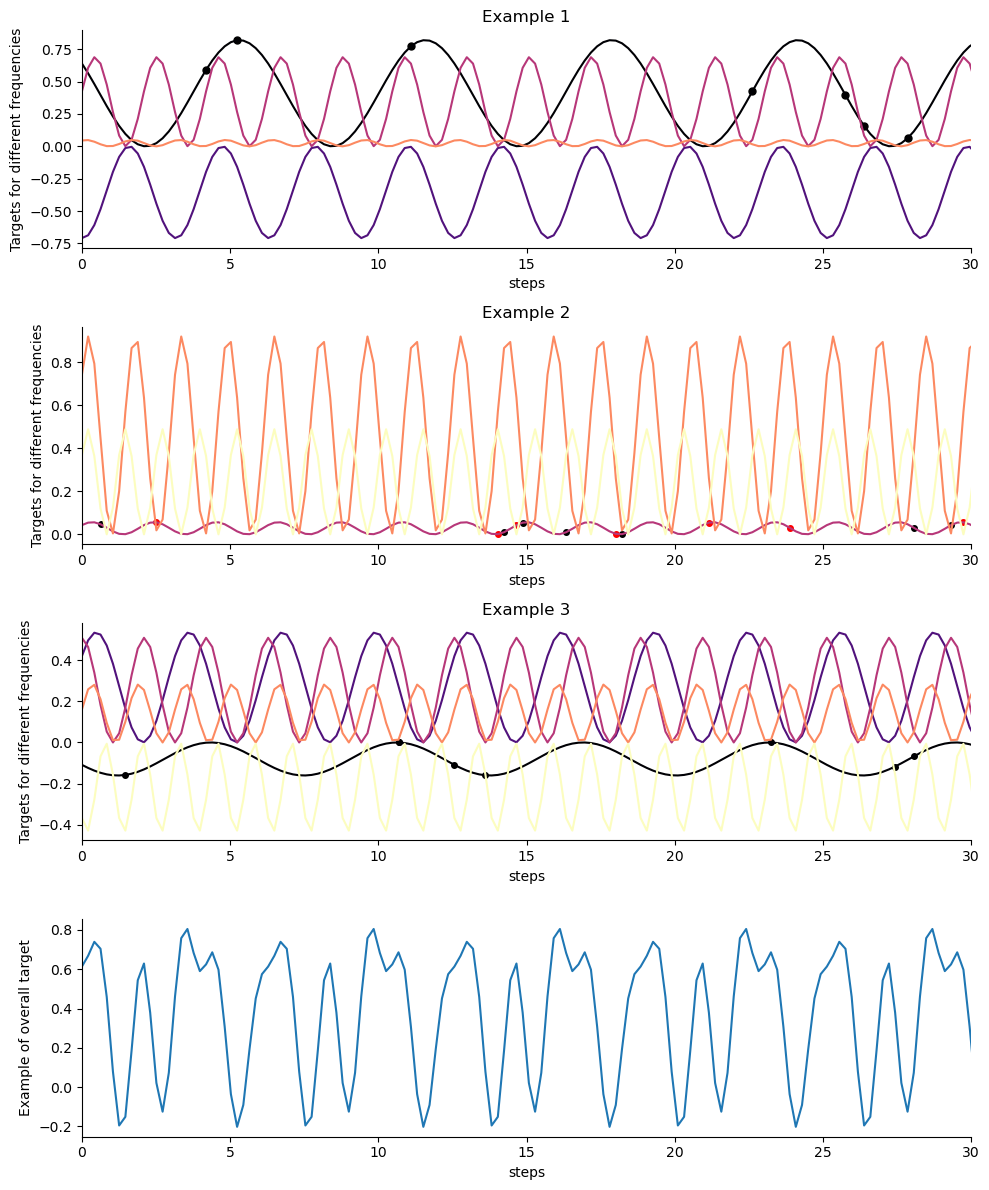

In [16]:
Sines=SineWaves(dts,X)
space=3
N_task=10
rand_sample=True
Rand=True
plt.rcParams["figure.autolayout"] = True


import matplotlib as mpl
colors = mpl.colormaps['magma'].resampled(Sines.N_F)


## Randomly sample a sine wave in the range of values considered 
if rand_sample==True:
    
    a=np.zeros([Sines.N_F])
    theta=np.zeros([Sines.N_F])
    
    for n in range(Sines.N_F):
        
        a[n]=np.random.uniform(Sines.As[n][0],Sines.As[n][1])
        theta[n]=np.random.uniform(Sines.phases[n][0],Sines.phases[n][1])

batch_size1=10
batch_size2=10

fig, ax = plt.subplots(4, 1,figsize=(10, 12))

S_T, T_T, x_data, y_data, n_t=Sines.Sample_1(a,theta,batch_size1,space)

## Plot thdata 

for  n in range(Sines.N_F-1):
    if n==0:
        ax[0].plot(dts[n_t].to('cpu'),T_T[:,n].to('cpu'),'.',markersize=10,color='black')
    
    ax[0].plot(dts.to('cpu'),y_data[:,n].to('cpu'),color=colors(n))

ax[0].set_xlabel('steps')
ax[0].set_ylabel('Targets for different frequencies')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlim(0, 30)
ax[0].set_title('Example 1')
    
T_T, S_T, N_t, T_q, S_q, N_q, As, Ths=Sines.Sample_Tr(N_task,batch_size1,batch_size2,space,Rand)

n_task=np.random.randint(0,N_task)
for n in range(2,Sines.N_F):
    if n==2:
        ax[1].plot(dts[N_t[n_task]].to('cpu'), T_T[n_task][:,n].to('cpu'), '.',markersize=8,color='black')
        ax[1].plot(dts[N_q[n_task]].to('cpu'), T_q[n_task][:,n].to('cpu'), '.',markersize=8,color='red')
    Y=As[n_task][n]*(torch.sin((n+1)*dts+Ths[n_task][n])+1)/2
    ax[1].plot(dts.to('cpu'), Y.to('cpu'),color=colors(n))


    
ax[1].set_xlabel('steps')
ax[1].set_ylabel('Targets for different frequencies')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlim(0, 30)
ax[1].set_title('Example 2')

#print(As[n_task], Ths[n_task])

Ss, Targets, N_T, x_datas, y_datas, As, Ths=Sines.sample_all(N_task,batch_size1,space,Rand)

Y1=torch.zeros([dts.size()[0]])
for n in range(0,Sines.N_F):
    if n==0:
        ax[2].plot(dts[N_T[n_task]].to('cpu'), Targets[n_task][:,n].to('cpu'), '.',markersize=8,color='black')
    Y=As[n_task][n]*(torch.sin((n+1)*dts+Ths[n_task][n])+1)/2
    Y1=Y1+Y
    ax[2].plot(dts.to('cpu'), Y.to('cpu'),color=colors(n))

ax[2].set_xlabel('steps')
ax[2].set_ylabel('Targets for different frequencies')
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)    
ax[2].set_xlim(0, 30)
ax[2].set_title('Example 3')

#print(As[n_task], Ths[n_task])

ax[3].plot(dts.to('cpu'),Y1.to('cpu'))
ax[3].set_xlabel('steps')
ax[3].set_ylabel('Example of overall target')
ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)    
ax[3].set_xlim(0, 30)


In [19]:
Ns=torch.tensor([X.size()[1],5,Sines.N_F])

K=15
Q=20
N_task=15
eta=1
eta_meta=0.000005
N_train=10000
t_steps=10
c=10
space=3

MLP=Meta_ReadOut(Ns,t_steps,eta)

MLP.Initialise_Hyperparameters(eta_meta,c,N_train,t_steps)

Sines=SineWaves(dts,X)

E_train=torch.zeros([N_train,N_task,t_steps])
L_train=torch.zeros([N_train,N_task,t_steps])
n_steps=1000

for n in range(N_train):
    

    T_T, S_T, N_t, T_q, S_q, N_q, As, Ths=Sines.Sample_Tr(N_task,K,Q,space,Rand=False)
    
    e_n, l=MLP.Meta(S_T, T_T, S_q, T_q, t_steps)
    
    E_train[n,:,:]=e_n[:,:].detach()
    L_train[n,:,:]=l[:,:].detach()    
    
    if n%500==0:
        
        Ss, Targets, N_T, x_datas, y_datas, As, Ths=Sines.sample_all(N_task*3,K,space,Rand=True)
        ES_tr, ES_all_tr, Ys_tr=MLP.Analysis(Ss, Targets, n_steps, x_datas, y_datas)
        
        print(n,'Performance:')
        
        ## Error on all the wave; it will give an idea of the generalisation ability over data not seen in
        ## the inner loop
        print('On all data': torch.mean(ES_all_tr[0:900],0))
        
        ## Error on inner loop data; 
        ## The discrepancy between the two metrics gives an idea of overfitting tendency
        print('On data seen during training': print(torch.mean(ES_tr[0:900],0)))
        

0
Performance:
tensor([0.1823, 0.1738, 0.1658,  ..., 0.0472, 0.0472, 0.0472])
tensor([0.1833, 0.1745, 0.1662,  ..., 0.0149, 0.0148, 0.0148])
None
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
24

1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946


3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
Perfo

4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
Performance:
tensor([0.1923, 0.0806, 0.0439,  ..., 0.0079, 0.0079, 0.0079])
tensor([0.1949, 0.0744, 0.0380,  ..., 0.0021, 0.0021, 0.0021])
None
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5

6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
Performance:
tensor([0.1750, 0.0737, 0.0393,  ..., 0.0067, 0.0067, 0.0067])
tensor([0.1680, 0.0655, 0.0332,  ..., 0.0018, 0.0018, 0.0018])
None
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569
6570
6571
6572
6573
6574
6575
6576
6577
6578
6579
6580
6581
6582
6

7966
7967
7968
7969
7970
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981
7982
7983
7984
7985
7986
7987
7988
7989
7990
7991
7992
7993
7994
7995
7996
7997
7998
7999
8000
Performance:
tensor([0.1743, 0.0711, 0.0370,  ..., 0.0065, 0.0065, 0.0065])
tensor([0.1729, 0.0651, 0.0322,  ..., 0.0017, 0.0017, 0.0017])
None
8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8

9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518
9519
9520
9521
9522
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632
9633
9634
9635
9636
9637
9638
9639
9640
9641
9642
9643
9644
9645
9646
9647
9648
9649
9650
9651
9652
9653
9654
9655
9656
9657
9658
9659
9660
9661
9662
9663
9664
9665
9666
9667
9668
9669
9670
9671
9672
9673
9674
9675
9676
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704


Different colors correspond to the network output after siverse nuber of updates
[ 0.454974    0.94270719  0.32779196 -0.30909851 -0.19220865] [2.34292381 0.78936611 0.17685993 0.43791107 0.16880118]


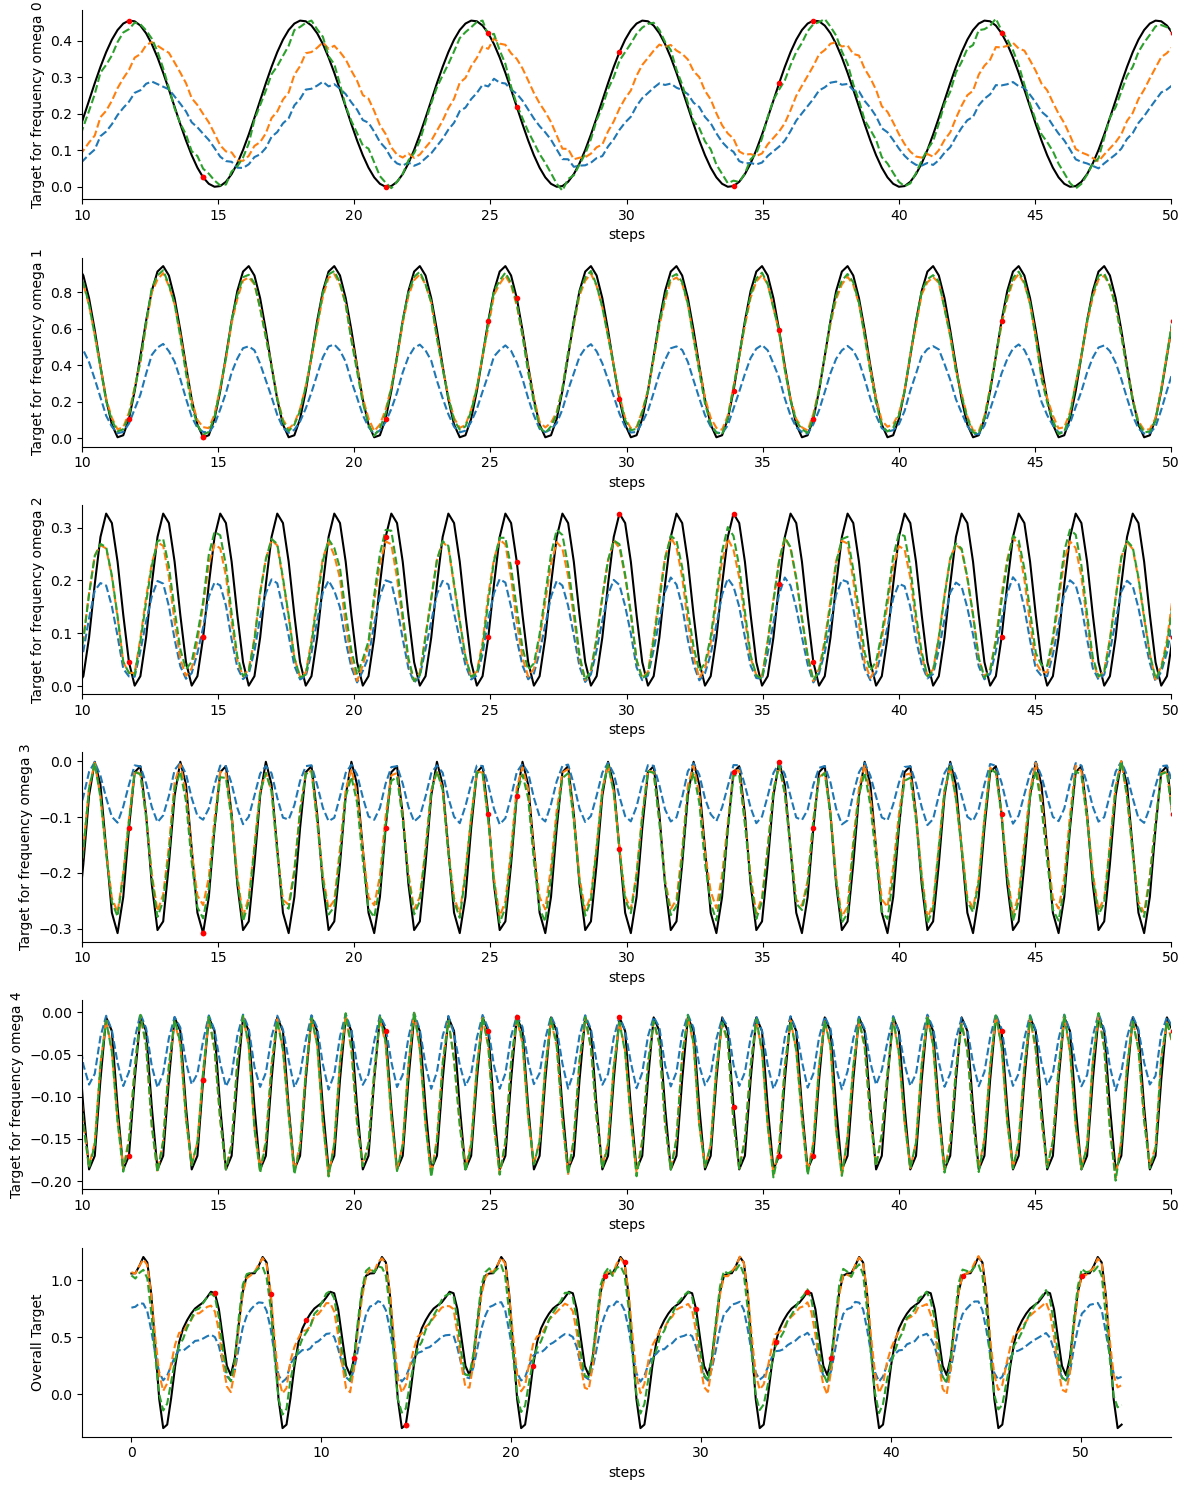

In [22]:
from scipy import io

n_points=15
space=2


rand_sample=True
if rand_sample==True:
    
    a=np.zeros([Sines.N_F])
    theta=np.zeros([Sines.N_F])
    
    for n in range(Sines.N_F):
        
        a[n]=np.random.uniform(Sines.As[n][0],Sines.As[n][1])
        theta[n]=np.random.uniform(Sines.phases[n][0],Sines.phases[n][1])
        
    
xs_t, s_t, x_data, y_data, n_t=Sines.Sample_1(a,theta,n_points,space,Rand=True)

n_steps=1000

E_n, E_all, Y_data=MLP.Fine_Tuning(xs_t, s_t, n_steps, x_data.to('cuda'), y_data.to('cuda'))


fig, ax = plt.subplots(6, 1,figsize=(12, 15))

print('Different colors correspond to the network output after siverse nuber of updates')
x_lim=10
X_lim=50
for n in range(Sines.N_F):
    
    ax[n].plot(dts,y_data[:,n].detach().to('cpu'),'black')
    ax[n].plot(dts,Y_data[2,:,n].detach().to('cpu'),'--')
    ax[n].plot(dts,Y_data[9,:,n].detach().to('cpu'),'--')
    ax[n].plot(dts,Y_data[999,:,n].detach().to('cpu'),'--')
    ax[n].plot(dts[n_t],s_t[:,n].to('cpu'),'.',color='red')
    ax[n].set_xlim([x_lim, X_lim])
    ax[n].set_xlabel('steps')
    ax[n].set_ylabel('Target for frequency omega '+str(n))
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['top'].set_visible(False)

    
ax[n+1].plot(dts, torch.sum(y_data,1).to('cpu'),'black' ) 
ax[n+1].plot(dts, torch.sum(Y_data[2,:,:],1).to('cpu'),'--' ) 
ax[n+1].plot(dts, torch.sum(Y_data[9,:,:],1).to('cpu'),'--' ) 
ax[n+1].plot(dts, torch.sum(Y_data[999,:,:],1).to('cpu'),'--' ) 
ax[n+1].plot(dts[n_t],torch.sum(s_t,1).to('cpu'),'.',color='red')
ax[n+1].set_xlabel('steps')
ax[n+1].set_ylabel('Overall Target')
ax[n+1].spines['right'].set_visible(False)
ax[n+1].spines['top'].set_visible(False)
print(a,theta)




### SAVING RESULTS

In [ ]:
title_start='Meta_Sines_Model'
title=title_start+'_Pred.npy'

Parameters=np.array( [np.array(Model.Ws.to('cpu')),np.array(Model.bs.to('cpu'))], dtype=object)

np.save(os.path.join(path, title), Pred, allow_pickle=True)

In [ ]:
from scipy import io

for j in range(1,100):

    n_points=j

    xs_t, s_t, x_data, y_data, n_t=Sines.Sample_1(a,theta,n_points,space,Rand=False)

    n_steps=1000

    E_n, E_all, Y_data=MLP.Fine_Tuning(xs_t, s_t, n_steps, x_data.to('cuda'), y_data.to('cuda'))
    Pred=np.array( [np.array(dts.to('cpu')),n_t,np.array(Y_data.to('cpu')),np.array(y_data.to('cpu')),\
                    np.array(E_n.to('cpu')),np.array(E_all.to('cpu')),a,theta], dtype=object)

    path="C:\\Users\lucam\Desktop\Meta\Data2"

    title_start='Meta_Sines_Ex6_'+str(n_points)
    title=title_start+'_space2.mat'
    io.savemat(os.path.join(path, title),{"array": Pred})



In [ ]:

path="C:\\Users\lucam\Desktop\Meta\Random_Examples"


Ex=np.arange(0,15)

for n in range(np.shape(Ex)[0]):
    
    #path="C:\\Users\lucam\Desktop\Clean\Meta_Results\Sines\Second_Data"
    
    path="C:\\Users\lucam\Desktop\Meta\Random_Examples"
    title_start='Meta_Sines_Ex'+str(Ex[n]+1)+'_10_Rand'
    title=title_start+'.mat'

    Pred=io.loadmat(os.path.join(path, title))
    a=Pred['array'][0][6][0]
    theta=Pred['array'][0][7][0]
    ns=np.arange(1,11)*3
    
    for j in range(10):

        n_points=ns[j]

        xs_t, s_t, x_data, y_data, n_t=Sines.Sample_1(a,theta,n_points,space,Rand=True)
        
        n_steps=1000

        E_n, E_all, Y_data=MLP.Fine_Tuning(xs_t, s_t, n_steps, x_data.to('cuda'), y_data.to('cuda'))
        Pred=np.array( [np.array(dts.to('cpu')),n_t,np.array(Y_data.to('cpu')),np.array(y_data.to('cpu')),\
                        np.array(E_n.to('cpu')),np.array(E_all.to('cpu')),a,theta], dtype=object)

        #path="C:\\Users\lucam\Desktop\Clean\Meta_Results\Sines\Meta0"
        path="C:\\Users\lucam\Desktop\Meta\Meta_single\Data"
        title_start='Meta_Single_Ex'+str(Ex[n])+'_'+str(n_points)
        title=title_start+'.mat'
        io.savemat(os.path.join(path, title),{"array": Pred})
    

In [ ]:
n_points=15
space=2

N_ex=500
for l in range(500,500+N_ex):
    
    for j in range(1,41):
        
        n_points=j
        rand_sample=True
        if rand_sample==True:

            a=np.zeros([Sines.N_F])
            theta=np.zeros([Sines.N_F])

            for n in range(Sines.N_F):

                a[n]=np.random.uniform(Sines.As[n][0],Sines.As[n][1])
                theta[n]=np.random.uniform(Sines.phases[n][0],Sines.phases[n][1])


        xs_t, s_t, x_data, y_data, n_t=Sines.Sample_1(a,theta,n_points,space,Rand=True)

        n_steps=1000

        E_n, E_all, Y_data=MLP.Fine_Tuning(xs_t, s_t, n_steps, x_data.to('cuda'), y_data.to('cuda'))

        #Pred=np.array( [np.array(dts.to('cpu')),n_t,np.array(Y_data.to('cpu')),np.array(y_data.to('cpu')),\
        #                    np.array(E_n.to('cpu')),np.array(E_all.to('cpu')),a,theta], dtype=object)
        
        
        Pred=np.array( [np.array(E_n.to('cpu')),np.array(E_all.to('cpu')),a,theta], dtype=object)

        
        path="C:\\Users\lucam\Desktop\Meta\Random_Errors"

        title_start='Meta_Sines_Ex'+str(l)+'_'+str(n_points)
        title=title_start+'_RandErrors.mat'
        io.savemat(os.path.join(path, title),{"array": Pred})

    
    
